### Import Libraries

In [1]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


Set up variables and hyperparameters for our model

In [2]:
neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 53                  
window_len = 7               # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training
merge_date = '2016-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin

Functions for preprocessing the data

In [3]:
def get_market_data(market, tag=True):
  """
  market: the full name of the cryptocurrency as spelled on coinmarketcap.com. eg.: 'bitcoin'
  tag: eg.: 'btc', if provided it will add a tag to the name of every column.
  returns: panda DataFrame
  This function will use the coinmarketcap.com url for provided coin/token page. 
  Reads the OHLCV and Market Cap.
  Converts the date format to be readable. 
  Makes sure that the data is consistant by converting non_numeric values to a number very close to 0.
  And finally tags each columns if provided.
  """
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end=20190707", flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


def merge_data(a, b, from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data


def add_volatility(data, coins=['BTC', 'ETH']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  #data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data[['Date']+[coin+metric for coin in ['BTC_', 'ETH_'] for metric in ['Close**','Volume']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['BTC', 'ETH'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an integer to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close**', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an integer to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close**'][window_len:].values / data[coin + '_Close**'][:-window_len].values) - 1


def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mse','accuracy'])
  model.summary()
  return model

Below are the functions for plotting the data and results after training

In [4]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(10,10))
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,9]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,9]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,9]])
  ax1.plot(pd.to_datetime(data['Date']),data[tag +'_Close**'])
  ax2.bar(pd.to_datetime(data['Date']).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close**'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close**'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

Load the market data into variables btc_data and eth_data:

In [5]:
btc_data = get_market_data("bitcoin", tag='BTC')
eth_data = get_market_data("ethereum", tag='ETH')

In [6]:
btc_data.head()

,Date,BTC_Open*,BTC_High,BTC_Low,BTC_Close**,BTC_Volume,BTC_Market Cap
0,2019-07-07,11217.62,11541.62,11148.80,11450.85,1.936904e+10,203881891346
1,2019-07-06,10982.54,11620.97,10982.54,11208.55,2.109202e+10,199546110914
2,2019-07-05,11203.10,11395.66,10874.96,10978.46,2.383848e+10,195424678267
3,2019-07-04,11972.72,12006.08,11166.57,11215.44,2.592029e+10,199617404432
4,2019-07-03,10818.16,11968.08,10818.16,11961.27,3.079649e+10,212867079175


C:\Users\shrey\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


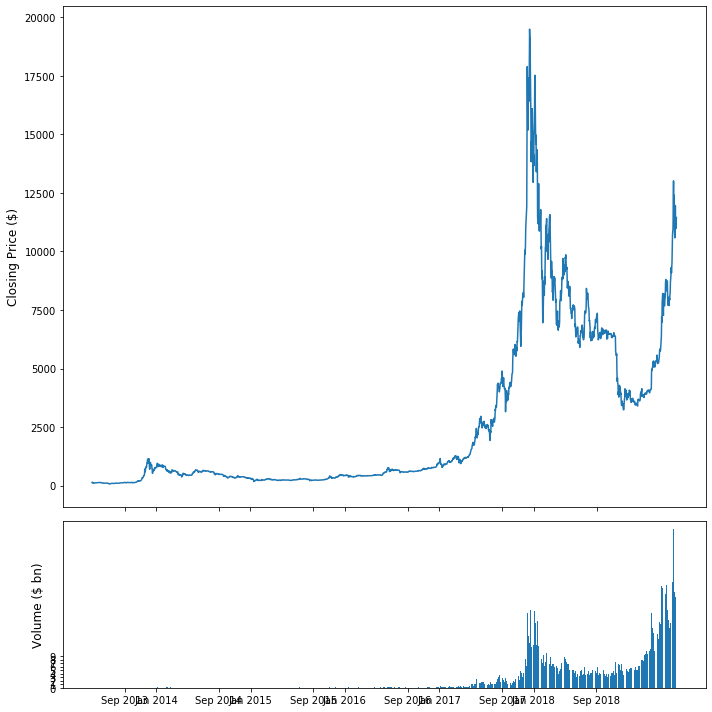

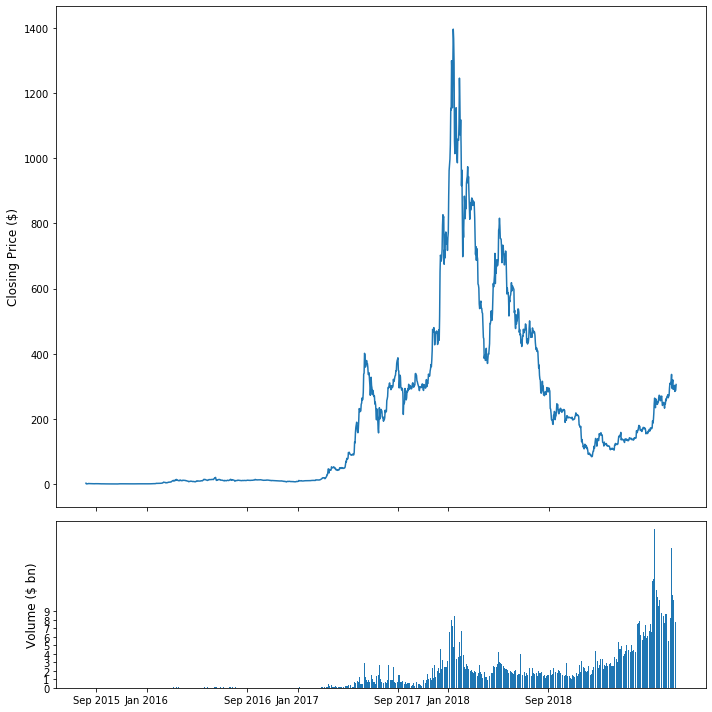

In [7]:
show_plot(btc_data, tag='BTC')
show_plot(eth_data, tag='ETH')

In [8]:
market_data = merge_data(btc_data, eth_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [9]:
model_data.head()

,Date,BTC_Close**,BTC_Volume,ETH_Close**,ETH_Volume
1283,2016-01-01,434.33,36278900.0,0.948024,206062
1282,2016-01-02,433.44,30096600.0,0.937124,255504
1281,2016-01-03,430.01,39633800.0,0.971905,407632
1280,2016-01-04,433.09,38477500.0,0.954480,346245
1279,2016-01-05,431.96,34522600.0,0.950176,219833


Pre-processing data and producing inputs and target outputs:

In [10]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='BTC')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='BTC')

Y_train_eth = create_outputs(train_set, coin='ETH')
Y_test_eth = create_outputs(test_set, coin='ETH')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(1020, 7, 4) (250, 7, 4) (1020,) (250,)
(1020, 7, 4) (250, 7, 4) (1020,) (250,)


Initializing the model and training it for predicting BTC price for next day:

In [11]:

# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(784)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

W0711 14:45:00.235070  9724 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 14:45:00.250445  9724 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 14:45:00.253422  9724 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 14:45:00.708409  9724 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0711 14:45:00.715848  9724 deprecation.py:506

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________

W0711 14:45:02.971686  9724 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1020 samples, validate on 250 samples
Epoch 1/53
1020/1020 [==============================] - 7s 7ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - acc: 9.8039e-04 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_acc: 0.0000e+00
Epoch 2/53
1020/1020 [==============================] - 4s 4ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - acc: 9.8039e-04 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_acc: 0.0000e+00
Epoch 3/53
1020/1020 [==============================] - 5s 5ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - acc: 9.8039e-04 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_acc: 0.0000e+00
Epoch 4/53
1020/1020 [==============================] - 4s 4ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - acc: 9.8039e-04 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_acc: 0.0000e+00
Epoch 5/53
1020/1020 [==============================] - 4s 4ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - acc: 9.8039e-04 - val_l

Epoch 41/53
1020/1020 [==============================] - 5s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - acc: 9.8039e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_acc: 0.0000e+00
Epoch 42/53
1020/1020 [==============================] - 5s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - acc: 9.8039e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_acc: 0.0000e+00
Epoch 43/53
1020/1020 [==============================] - 5s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - acc: 9.8039e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_acc: 0.0000e+00
Epoch 44/53
1020/1020 [==============================] - 5s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - acc: 9.8039e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_acc: 0.0000e+00
Epoch 45/53
1020/1020 [==============================] - 5s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - acc: 9.8039e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.00

Plot the results:

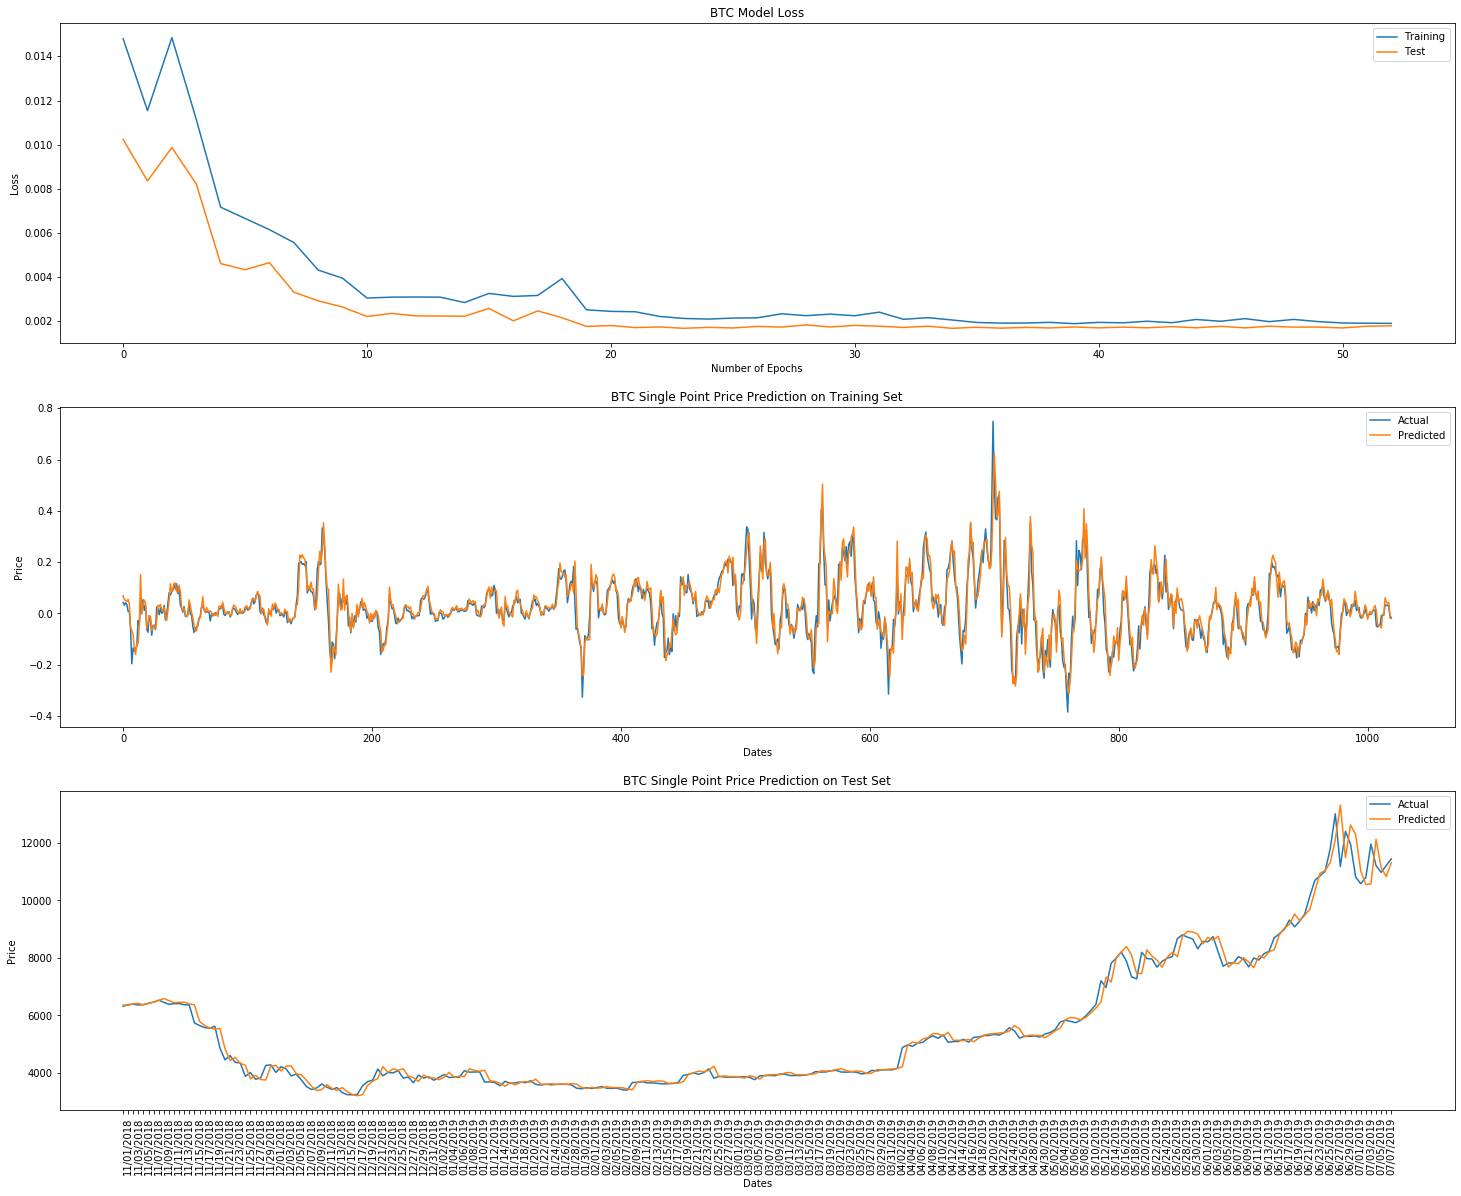

In [12]:
plot_results(btc_history, btc_model, Y_train_btc, coin='BTC')

Initializing the model and training it for predicting ETH price for next day:

In [ ]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
__________

In [ ]:
plot_results(eth_history, eth_model, Y_train_eth, coin='ETH')